In [1]:
import pandas as pd
import sklearn
import re
import catboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import classification_report, plot_confusion_matrix, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

## First look

In [2]:
main_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
PassengerID = test_df['PassengerId']
Survived = main_df['Survived']

In [3]:
main_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## Dealing with NaNs

In [5]:
main_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
test_df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [7]:
def get_rid_of_nans(df):
    df['Age'].fillna(value = df['Age'].mean(), inplace = True)
    df['Fare'].fillna(value = df['Fare'].mean(), inplace = True)
    df['Embarked'].fillna(value = df['Embarked'].mode()[0], inplace = True)
    df['Cabin'].fillna(value = 'NoCabin', inplace = True)
    re_cabin_template = "[A-Za-z]+"
    df['Cabin'] = df['Cabin'].apply(lambda x: re.search(re_cabin_template, x).group(0))

In [8]:
get_rid_of_nans(main_df)
get_rid_of_nans(test_df)

In [9]:
main_df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Feature engineering

In [10]:
def make_title(df):
    re_title_template = '([A-Za-z]+)\.'
    df['Title'] = df.Name.apply(lambda x: re.search(re_title_template, x).group(1))

In [11]:
make_title(main_df)
make_title(test_df)

In [12]:
main_df.Title.value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Col           2
Major         2
Capt          1
Sir           1
Countess      1
Jonkheer      1
Lady          1
Mme           1
Don           1
Ms            1
Name: Title, dtype: int64

In [13]:
def replace_title_name(x):
    title = x['Title']
    man_mr_titles = ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col', 'Sir']
    woman_mrs_titles = ['Countess', 'Mme','Dona']
    woman_miss_titles = ['Mlle', 'Ms','Lady']
    if title in man_mr_titles:
        return 'Mr'
    elif title in woman_mrs_titles:
        return 'Mrs'
    elif title in woman_miss_titles:
        return 'Miss'
    elif title =='Dr':
        if x['Sex'] == 'Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

In [14]:
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.50000,0,0,330911,7.8292,NoCabin,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00000,1,0,363272,7.0000,NoCabin,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.00000,0,0,240276,9.6875,NoCabin,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.00000,0,0,315154,8.6625,NoCabin,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00000,1,1,3101298,12.2875,NoCabin,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,30.27259,0,0,A.5. 3236,8.0500,NoCabin,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.00000,0,0,PC 17758,108.9000,C,C,Dona
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.50000,0,0,SOTON/O.Q. 3101262,7.2500,NoCabin,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,30.27259,0,0,359309,8.0500,NoCabin,S,Mr


In [15]:
main_df['Title'] = main_df.apply(replace_title_name, axis = 1)
test_df['Title'] = test_df.apply(replace_title_name, axis = 1)

In [16]:
main_df.Title.value_counts()

Mr        531
Miss      186
Mrs       134
Master     40
Name: Title, dtype: int64

In [17]:
test_df.Title.value_counts()

Mr        244
Miss       79
Mrs        74
Master     21
Name: Title, dtype: int64

In [18]:
def make_features(df):
    children_with_nanny = (df['Age']<18) & (df['Parch']==0)
    df['Family_Size'] = df['SibSp'] + df['Parch']
    # children without parents travell with nanny
    df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)
    # family size and the person himself
    df['Fare_Per_Person'] = df['Fare'] / (df['Family_Size'] + 1)
    df['Age*Class'] = df['Age'] * df['Pclass']

In [19]:
make_features(main_df)
make_features(test_df)

<ipython-input-18-e57317e3a635>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)
<ipython-input-18-e57317e3a635>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Family_Size[children_with_nanny] = df.apply(lambda x: x['SibSp'] + 1, axis = 1)


In [20]:
def drop_columns(df):
    columns_to_drop = ['PassengerId', 'Ticket','Name', 'Cabin', 'Embarked'] # 'Cabin', 'Embarked' maybe too
    if 'Survived' in df.columns:
        columns_to_drop.append('Survived')
    df.drop(columns = columns_to_drop, inplace = True)
#     columns_to_drop = ['SibSp', 'Parch', 'Fare']
#     df.drop(columns = columns_to_drop, inplace = True)

In [21]:
drop_columns(main_df)
drop_columns(test_df)

## Data preprocessing

In [22]:
rand_state = 200

In [23]:
main_df.dtypes

Pclass               int64
Sex                 object
Age                float64
SibSp                int64
Parch                int64
Fare               float64
Title               object
Family_Size          int64
Fare_Per_Person    float64
Age*Class          float64
dtype: object

In [24]:
# def make_obj_features(df):
#     obj_features = ['Pclass']
#     df[obj_features] = df[obj_features].astype('object')

In [25]:
# make_obj_features(test_df)
# make_obj_features(main_df)

In [26]:
def encoding_columns(df):
#     LE = LabelEncoder()
#     for feature in df.select_dtypes(include = ['object']):
#         df[feature] = LE.fit_transform(df[feature])
    df = pd.get_dummies(df)
    return df

In [27]:
main_df = encoding_columns(main_df)
test_df = encoding_columns(test_df)

In [28]:
main_df_columns = set(main_df.columns)
test_df_columns = set(test_df.columns)
print(main_df_columns.difference(test_df_columns))
print(test_df_columns.difference(main_df_columns))

set()
set()


In [29]:
# main_df.drop(columns = ['Cabin_T'], inplace =True)

In [30]:
def custom_train_test_split(data, target_data):
    train_data, valid_data, train_value, valid_value  = train_test_split(data, target_data, test_size = 0.2, random_state = rand_state, shuffle = True)
    return train_data, valid_data, train_value, valid_value

In [31]:
train_data, valid_data, train_value, valid_value  = custom_train_test_split(main_df, Survived)

# Some experiments before training in order to find out approximately which parameters are best

In [32]:
def get_cv_scored(check_param_list, param_name, model_params, ml_model):
    mean_cv_scores = []
    std_cv_scores = []
    for item in check_param_list:
        model_params[param_name] = item
        ml_model.set_params(**model_params)
        cv_scores = cross_val_score(ml_model, train_data, train_value, cv = 5)
        mean_score = cv_scores.mean()
        std_score = cv_scores.std()
        mean_cv_scores.append(mean_score)
        std_cv_scores.append(std_score)
        print("Param {} value: {}".format(param_name, item))
        print("Mean_cv_score: {}".format(mean_score))
        print("Std_cv_score: {}".format(std_score))
        print(cv_scores)
    return mean_cv_scores, std_cv_scores

In [33]:
def plot_cv_report(std_cv_scores, mean_cv_scores, ml_parameters,  ml_parameter_name):
    plt.xlabel(ml_parameter_name)
    plt.ylabel("std cv_score")
    plt.title("Dependency between a Cross Validation's Standard Deviation score and {}".format(ml_parameter_name))
    plt.plot(ml_parameters, std_cv_scores)
    plt.show()
    plt.xlabel(ml_parameter_name)
    plt.ylabel("mean cv_score")
    plt.title("Dependency between a Cross Validation' mean score and {}".format(ml_parameter_name))
    plt.plot(ml_parameters, mean_cv_scores)
    plt.show()

Param n_estimators value: 100
Mean_cv_score: 0.8468925440756425
Std_cv_score: 0.015831115877849956
[0.86013986 0.84615385 0.85915493 0.85211268 0.81690141]
Param n_estimators value: 200
Mean_cv_score: 0.8483108440854921
Std_cv_score: 0.013828768835330817
[0.85314685 0.84615385 0.86619718 0.85211268 0.82394366]
Param n_estimators value: 300
Mean_cv_score: 0.8454939426770413
Std_cv_score: 0.01345977436179425
[0.86013986 0.83916084 0.85915493 0.84507042 0.82394366]
Param n_estimators value: 400
Mean_cv_score: 0.8468925440756425
Std_cv_score: 0.013087203463253622
[0.86013986 0.84615385 0.85915493 0.84507042 0.82394366]
Param n_estimators value: 500
Mean_cv_score: 0.8454939426770413
Std_cv_score: 0.011918213306826582
[0.85314685 0.84615385 0.85915493 0.84507042 0.82394366]
Param n_estimators value: 600
Mean_cv_score: 0.8440953412784399
Std_cv_score: 0.011334081760019071
[0.84615385 0.84615385 0.85915493 0.84507042 0.82394366]
Param n_estimators value: 700
Mean_cv_score: 0.8440953412784399
S

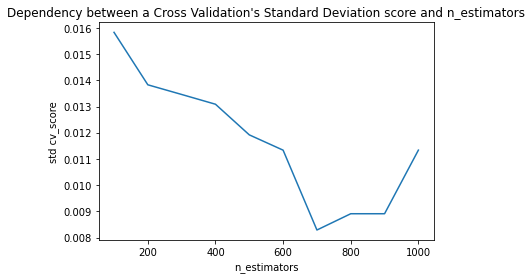

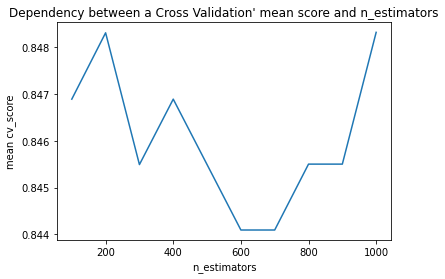

In [34]:
params = {'max_depth': 10, 'random_state' : rand_state, 'criterion' : 'entropy', 'min_samples_split' : 10, 'min_samples_leaf' : 5}
n_estimators = [i for i in range(100,1100,100)]
check_param_name = 'n_estimators'
mean_cv_scores, std_cv_scores = get_cv_scored(n_estimators, check_param_name, params, RandomForestClassifier())
plot_cv_report(std_cv_scores, mean_cv_scores, n_estimators,  check_param_name)

Param n_estimators value: 100
Mean_cv_score: 0.8244755244755245
Std_cv_score: 0.02485455052008655
[0.83216783 0.79020979 0.86619718 0.81690141 0.81690141]
Param n_estimators value: 300
Mean_cv_score: 0.8384713877671623
Std_cv_score: 0.010125881376235785
[0.84615385 0.83916084 0.85211268 0.82394366 0.83098592]
Param n_estimators value: 500
Mean_cv_score: 0.8384615384615385
Std_cv_score: 0.012837745300851796
[0.85314685 0.83916084 0.85211268 0.82394366 0.82394366]
Param n_estimators value: 700
Mean_cv_score: 0.8468629961587707
Std_cv_score: 0.024812306921546384
[0.86713287 0.86013986 0.87323944 0.81690141 0.81690141]
Param n_estimators value: 900
Mean_cv_score: 0.8440460947503201
Std_cv_score: 0.025251771847067065
[0.86013986 0.86713287 0.86619718 0.80985915 0.81690141]
Param n_estimators value: 1100
Mean_cv_score: 0.8440460947503201
Std_cv_score: 0.02601487456936369
[0.85314685 0.87412587 0.86619718 0.80985915 0.81690141]
Param n_estimators value: 1300
Mean_cv_score: 0.8426474933517187


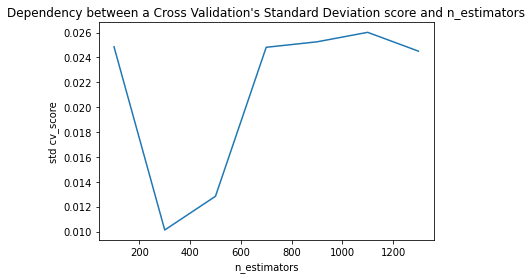

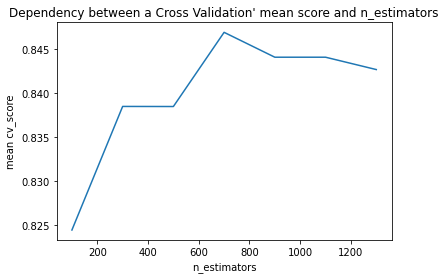

In [35]:
params = {'max_depth': 4, 'random_state' : rand_state, 'min_samples_split' : 10, 'min_samples_leaf' : 5, 'max_features' : 'sqrt', 'learning_rate' : 0.01}
n_estimators = [i for i in range(100,1500,200)]
check_param_name = 'n_estimators'
mean_cv_scores, std_cv_scores = get_cv_scored(n_estimators, check_param_name, params, GradientBoostingClassifier())
plot_cv_report(std_cv_scores, mean_cv_scores, n_estimators,  check_param_name)

Param max_depth value: 3
Mean_cv_score: 0.8426770412685907
Std_cv_score: 0.017132855100799385
[0.86713287 0.83216783 0.85915493 0.82394366 0.83098592]
Param max_depth value: 5
Mean_cv_score: 0.8482714468629962
Std_cv_score: 0.02404804331215068
[0.85314685 0.87412587 0.87323944 0.82394366 0.81690141]
Param max_depth value: 7
Mean_cv_score: 0.8384024426277946
Std_cv_score: 0.02637212230135369
[0.86013986 0.87412587 0.83802817 0.8028169  0.81690141]
Param max_depth value: 9
Mean_cv_score: 0.8341770905151187
Std_cv_score: 0.032976710781823335
[0.86013986 0.87412587 0.84507042 0.78873239 0.8028169 ]
Param max_depth value: 11
Mean_cv_score: 0.8369939919235694
Std_cv_score: 0.028001854772176062
[0.86713287 0.86713287 0.83802817 0.79577465 0.81690141]
Param max_depth value: 13
Mean_cv_score: 0.8341869398207425
Std_cv_score: 0.02771674053907137
[0.86013986 0.86713287 0.83802817 0.79577465 0.80985915]


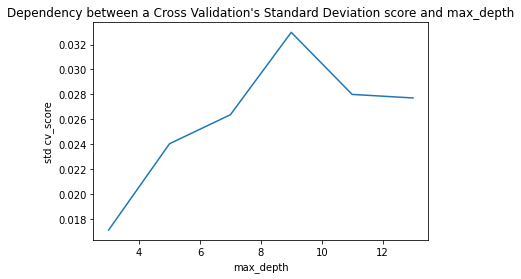

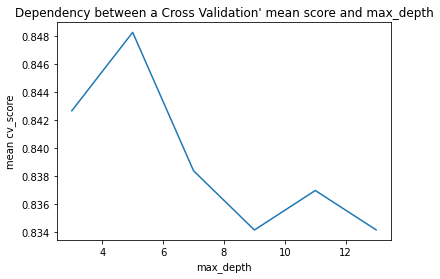

In [36]:
params = {'n_estimators': 1000, 'random_state' : rand_state, 'min_samples_split' : 10, 'min_samples_leaf' : 5, 'max_features' : 'sqrt', 'learning_rate' : 0.01}
max_depth = [i for i in range(3,15,2)]
check_param_name = 'max_depth'
mean_cv_scores, std_cv_scores = get_cv_scored(max_depth, check_param_name, params, GradientBoostingClassifier())
plot_cv_report(std_cv_scores, mean_cv_scores, max_depth,  check_param_name)

## Building and train a RandomForest Model

In [37]:
# 'max_samples': [200, 300, 400, 500]
def get_random_forest_model():
    RFC = RandomForestClassifier(n_estimators = 5000, max_depth = 5, min_samples_split = 10, min_samples_leaf = 5, random_state = rand_state)
#     tuned_parameters = [{'n_estimators': [100, 150, 200,250],
#                         'max_depth' : [4,5,6]}]
#     Random_Forest = RandomForestClassifier(random_state = rand_state, 
#                                            criterion = 'entropy', min_samples_split = 10, min_samples_leaf = 5)
    #RFC = GridSearchCV(Random_Forest, tuned_parameters)
    return RFC

In [38]:
RFC = get_random_forest_model()
RFC.fit(train_data, train_value)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=5000, random_state=200)

## Building a Gradient Boostring ML model

In [39]:
def get_gradient_boosting_model():

    GBC = GradientBoostingClassifier(random_state = rand_state, min_samples_split = 10, n_estimators = 1000, max_depth = 5,
                                                   min_samples_leaf = 5, learning_rate = 0.01)

#     tuned_parameters = [{,
#                         'max_depth': [3, 4, 9, 17]}]
#     Gradient_Boosting = GradientBoostingClassifier(max_depth = 4, random_state = rand_state, min_samples_split = 10, n_estimators = 1300,
#                                                    min_samples_leaf = 5, max_features = 'sqrt', learning_rate = 0.01)
#     GBC = GridSearchCV(Gradient_Boosting, tuned_parameters)
    return GBC

In [40]:
GBC = get_gradient_boosting_model()
GBC.fit(train_data, train_value)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=1000,
                           random_state=200)

## Building a CatBoost model

In [41]:
train_pool = catboost.Pool(
    train_data,
    label=train_value
)
val_pool = catboost.Pool(
    valid_data,
    label=valid_value
)

In [42]:
catboost_train_dir = 'catboost_train_dir'
!rmdir /S /Q catboost_train_dir
!mkdir catboost_train_dir

In [43]:
catboost_clf = catboost.CatBoostClassifier(
    eval_metric='AUC',
    od_pval=0.05,
    od_wait=20,
    learning_rate = 0.01,
    depth = 5,
    # early_stopping_rounds=20,
    # random_seed = rand_state,
    random_seed = rand_state,
    train_dir=catboost_train_dir,
    #task_type='CPU',
    task_type='GPU',
    # devices='0',
    auto_class_weights='Balanced',
    max_ctr_complexity=4,
    use_best_model=True
)
catboost_clf.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8902622	test: 0.8153846	best: 0.8153846 (0)	total: 30.4ms	remaining: 30.4s
1:	learn: 0.8935446	test: 0.8153846	best: 0.8153846 (0)	total: 64.5ms	remaining: 32.2s
2:	learn: 0.9018600	test: 0.8261538	best: 0.8261538 (2)	total: 96.7ms	remaining: 32.1s
3:	learn: 0.9012120	test: 0.8246795	best: 0.8261538 (2)	total: 129ms	remaining: 32.1s
4:	learn: 0.9029584	test: 0.8241667	best: 0.8261538 (2)	total: 162ms	remaining: 32.3s
5:	learn: 0.9052224	test: 0.8205128	best: 0.8261538 (2)	total: 210ms	remaining: 34.8s
6:	learn: 0.9040357	test: 0.8235897	best: 0.8261538 (2)	total: 261ms	remaining: 37.1s
7:	learn: 0.9044818	test: 0.8239743	best: 0.8261538 (2)	total: 307ms	remaining: 38.1s
8:	learn: 0.9034381	test: 0.8229487	best: 0.8261538 (2)	total: 354ms	remaining: 38.9s
9:	learn: 0.9033203	test: 0.8220513	best: 0.8261538 (2)	total: 399ms	remaining: 39.5s
10:	learn: 0.9050162	test: 0.8168589	best: 0.8261538 (2)	total: 446ms	remaining: 40.1s
11:	learn: 0.9049489	test: 0.8171154	best: 0.82615

95:	learn: 0.9195808	test: 0.8180128	best: 0.8261538 (2)	total: 4.28s	remaining: 40.3s
96:	learn: 0.9194967	test: 0.8181410	best: 0.8261538 (2)	total: 4.33s	remaining: 40.3s
97:	learn: 0.9196145	test: 0.8173718	best: 0.8261538 (2)	total: 4.37s	remaining: 40.2s
98:	learn: 0.9192863	test: 0.8161539	best: 0.8261538 (2)	total: 4.41s	remaining: 40.2s
99:	learn: 0.9192442	test: 0.8161539	best: 0.8261538 (2)	total: 4.46s	remaining: 40.1s
100:	learn: 0.9192105	test: 0.8161539	best: 0.8261538 (2)	total: 4.5s	remaining: 40.1s
101:	learn: 0.9200943	test: 0.8138461	best: 0.8261538 (2)	total: 4.55s	remaining: 40.1s
102:	learn: 0.9201195	test: 0.8138461	best: 0.8261538 (2)	total: 4.59s	remaining: 40s
103:	learn: 0.9202542	test: 0.8132052	best: 0.8261538 (2)	total: 4.65s	remaining: 40s
104:	learn: 0.9203047	test: 0.8132052	best: 0.8261538 (2)	total: 4.7s	remaining: 40s
105:	learn: 0.9204141	test: 0.8132052	best: 0.8261538 (2)	total: 4.74s	remaining: 40s
106:	learn: 0.9204225	test: 0.8132052	best: 0.8

limit_output extension: Maximum message size of 10000 exceeded with 10235 characters

## Wriring results to the CSV file submission

In [44]:
def make_csv_sub(df, PassengerID, rfc_classifier, filename):
    test_predictions = rfc_classifier.predict(df)
    submit_df = pd.DataFrame({"PassengerID": PassengerID, "Survived": test_predictions})
    submit_df.to_csv(filename, index = False)

In [45]:
make_csv_sub(test_df, PassengerID, RFC, 'gener_submission_rfc.csv')
make_csv_sub(test_df, PassengerID, GBC, 'gener_submission_gbc.csv')
make_csv_sub(test_df, PassengerID, catboost_clf, 'gener_submission_catboost_clf.csv')
# value_predicted = RFC.predict(valid_data)

## PostHoc Analysis

In [46]:
test_metrics = catboost_clf.eval_metrics(
    val_pool,
    metrics=['AUC', 'Accuracy', 'Precision', 'Recall', 'F1'],
    ntree_start=catboost_clf.best_iteration_ - 1,
    ntree_end=catboost_clf.best_iteration_,
    eval_period=1,
    thread_count=-1
)
test_metrics

{'AUC': [0.8153846153846154],
 'Accuracy': [0.7510917045025287],
 'Precision': [0.8695652146871238],
 'Recall': [0.64],
 'F1': [0.7373271879679676]}

In [47]:
def get_feature_importancy(ml_model):
    try:
        feature_importancy = ml_model.best_estimator_.feature_importances_
    except:
        feature_importancy = ml_model.feature_importances_
    return feature_importancy

In [48]:
def get_ml_params(ml_model):
    try:
        ml_params = ml_model.best_estimator_.get_params()
    except:
        ml_params = ml_model.get_params()
    return ml_params

In [49]:
def get_feature_importance_df(train_data, ml_model):
    feature_importancy = get_feature_importancy(ml_model)
    feature_imp_df = pd.DataFrame({'Feature': train_data.columns , 'Importance': feature_importancy })
    feature_imp_df = feature_imp_df.sort_values('Importance', ascending = False)
    return feature_imp_df

In [50]:
def make_metrics_report(y_test, y_pred):
    print(classification_report(y_test,y_pred))
    print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("ROC-AUC score: {}".format(roc_auc_score(y_test, y_pred)))

In [51]:
def make_feature_importance_report(df, ml_model_name):
    print("ML model name: {} \n".format(ml_model_name))
    print(df)
    sns.barplot(x = df['Importance'], y = df['Feature'] )

In [52]:
def make_post_hoc_report(ml_model, valid_data, valid_value, ml_model_name):
    print("ML model name: {} \n".format(ml_model_name))
    ml_params = get_ml_params(ml_model)
    print("ML_model parameters: \n\n {} \n".format(ml_params))
    plot_confusion_matrix(ml_model, valid_data, valid_value)
    value_predicted = ml_model.predict(valid_data)
    make_metrics_report(valid_value, value_predicted)

In [53]:
feature_imp_df_rfc = get_feature_importance_df(train_data, RFC)
feature_imp_df_gbc = get_feature_importance_df(train_data, GBC)

ML model name: GradientBoostingClassifier 

ML_model parameters: 

 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_iter_no_change': None, 'random_state': 200, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.80      0.87      0.83       104
           1       0.79      0.71      0.75        75

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

Accuracy score: 0.7988826815642458
ROC-AUC score: 0.786025641025641


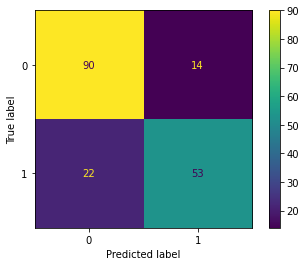

In [54]:
make_post_hoc_report(GBC, valid_data, valid_value, "GradientBoostingClassifier")

ML model name: RandomForestClassifier 

ML_model parameters: 

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5000, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       104
           1       0.80      0.65      0.72        75

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179

Accuracy score: 0.7877094972067039
ROC-AUC score: 0.768974358974359


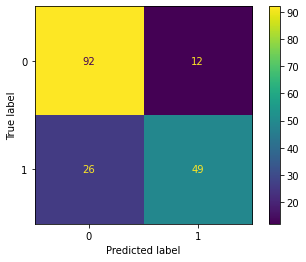

In [55]:
make_post_hoc_report(RFC, valid_data, valid_value, 'RandomForestClassifier')

ML model name: RandomForestClassifier 

            Feature  Importance
12         Title_Mr    0.199680
8        Sex_female    0.141033
9          Sex_male    0.138606
6   Fare_Per_Person    0.091401
7         Age*Class    0.081139
0            Pclass    0.069335
4              Fare    0.068597
11       Title_Miss    0.053130
5       Family_Size    0.047995
1               Age    0.036474
2             SibSp    0.030800
13        Title_Mrs    0.018955
10     Title_Master    0.011994
3             Parch    0.010861


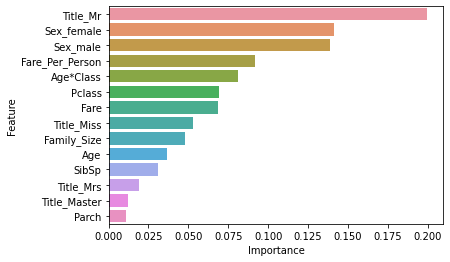

In [56]:
make_feature_importance_report(feature_imp_df_rfc, "RandomForestClassifier")

ML model name: GradientBoostingClassifier 

            Feature  Importance
12         Title_Mr    0.417149
6   Fare_Per_Person    0.164981
7         Age*Class    0.090954
5       Family_Size    0.083655
4              Fare    0.075116
0            Pclass    0.069254
1               Age    0.063480
8        Sex_female    0.009104
9          Sex_male    0.007591
3             Parch    0.005614
2             SibSp    0.003690
13        Title_Mrs    0.003420
11       Title_Miss    0.003132
10     Title_Master    0.002859


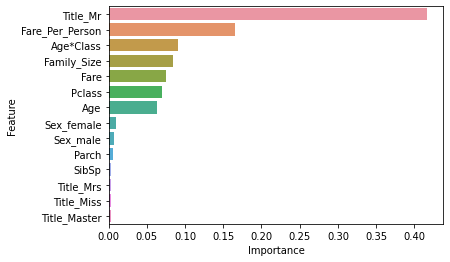

In [57]:
make_feature_importance_report(feature_imp_df_gbc, 'GradientBoostingClassifier')

# Make new model based on the knowledge of the feature importance

## a new random forest

In [58]:
def get_dfs_with_most_important_features(test_df, feature_imp_df, N_features):
    print("Number of features total: {}".format(len(test_df.columns)))
    print("Number of features selected: {}".format(N_features))
    selected_imp_features = feature_imp_df['Feature'][:N_features].to_list()
    test_df_most_imp = test_df[selected_imp_features]
    main_df_most_imp = main_df[selected_imp_features]
    return test_df_most_imp, main_df_most_imp

In [59]:
test_df_most_imp, main_df_most_imp = get_dfs_with_most_important_features(test_df, feature_imp_df_rfc, 6)
train_data, valid_data, train_value, valid_value  = custom_train_test_split(main_df_most_imp, Survived)

Number of features total: 14
Number of features selected: 6


In [60]:
RFC_new = get_random_forest_model()
RFC_new.fit(train_data, train_value)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=5000, random_state=200)

ML model name: RandomForestClassifier 

ML_model parameters: 

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5000, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       104
           1       0.78      0.67      0.72        75

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Accuracy score: 0.7821229050279329
ROC-AUC score: 0.766025641025641


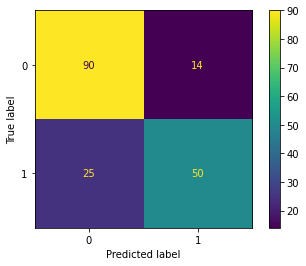

In [61]:
make_post_hoc_report(RFC_new, valid_data, valid_value, 'RandomForestClassifier')

In [62]:
make_csv_sub(test_df_most_imp, PassengerID, RFC_new, 'gender_submission_rfc_new.csv')

## a new gradient boosting classificator

In [63]:
test_df_most_imp, main_df_most_imp = get_dfs_with_most_important_features(test_df, feature_imp_df_gbc, 6)

Number of features total: 14
Number of features selected: 6


In [64]:
train_data, valid_data, train_value, valid_value  = custom_train_test_split(main_df_most_imp, Survived)

In [65]:
GBC_new = get_gradient_boosting_model()
GBC_new.fit(train_data, train_value)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=1000,
                           random_state=200)

ML model name: GradientBoostingClassifier 

ML_model parameters: 

 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_iter_no_change': None, 'random_state': 200, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       104
           1       0.81      0.72      0.76        75

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Accuracy score: 0.8100558659217877
ROC-AUC score: 0.7975


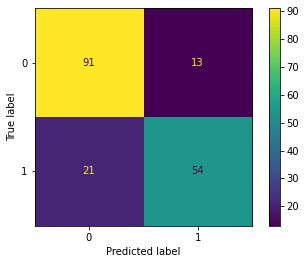

In [66]:
make_post_hoc_report(GBC_new, valid_data, valid_value, 'GradientBoostingClassifier')

In [67]:
make_csv_sub(test_df_most_imp, PassengerID, GBC_new, 'gender_submission_gbc_new.csv')

## Just for fun, no train test split, lets see what would we get). But we know optimal parameters, maybe it would help

In [68]:
RFC_no_valid = get_random_forest_model()
RFC_no_valid .fit(main_df, Survived)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=5000, random_state=200)

In [69]:
GBC_no_valid  = get_gradient_boosting_model()
GBC_no_valid .fit(main_df, Survived)

GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           min_samples_split=10, n_estimators=1000,
                           random_state=200)

ML model name: GradientBoostingClassifier 

ML_model parameters: 

 {'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_iter_no_change': None, 'random_state': 200, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       549
           1       0.96      0.89      0.92       342

    accuracy                           0.94       891
   macro avg       0.95      0.93      0.94       891
weighted avg       0.94      0.94      0.94       891

Accuracy score: 0.9427609427609428
ROC-AUC score: 0.9326047358834244


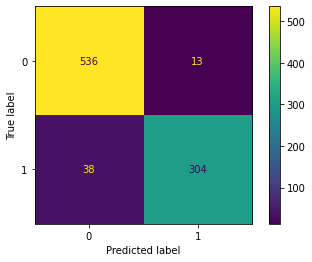

In [70]:
make_post_hoc_report(GBC_no_valid, main_df, Survived, 'GradientBoostingClassifier')

ML model name: RandomForestClassifier 

ML_model parameters: 

 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 5, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5000, 'n_jobs': None, 'oob_score': False, 'random_state': 200, 'verbose': 0, 'warm_start': False} 

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       549
           1       0.83      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.84      0.82      0.83       891
weighted avg       0.84      0.84      0.84       891

Accuracy score: 0.8417508417508418
ROC-AUC score: 0.8225242066915924


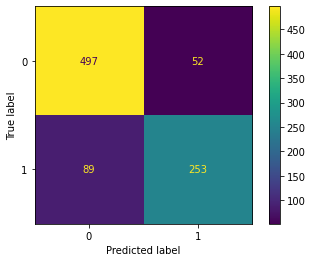

In [71]:
make_post_hoc_report(RFC_no_valid, main_df, Survived, 'RandomForestClassifier')

In [72]:
make_csv_sub(test_df, PassengerID, GBC_no_valid, 'gender_submission_gbc_no_valid.csv')
make_csv_sub(test_df, PassengerID, RFC_no_valid, 'gender_submission_rfc_no_valid.csv')